<a href="https://colab.research.google.com/github/ikanx101/G-Colab/blob/main/Finding_best_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
#system("sudo apt-get install libglpk-dev")
#install.packages("ROI")
#install.packages("ompr")
#install.packages("ompr.roi")
#install.packages("ROI.plugin.glpk")

In [131]:
library(dplyr)
library(ompr)
library(ompr.roi)
library(ROI.plugin.glpk)
library(ggplot2)

rm(list=ls())

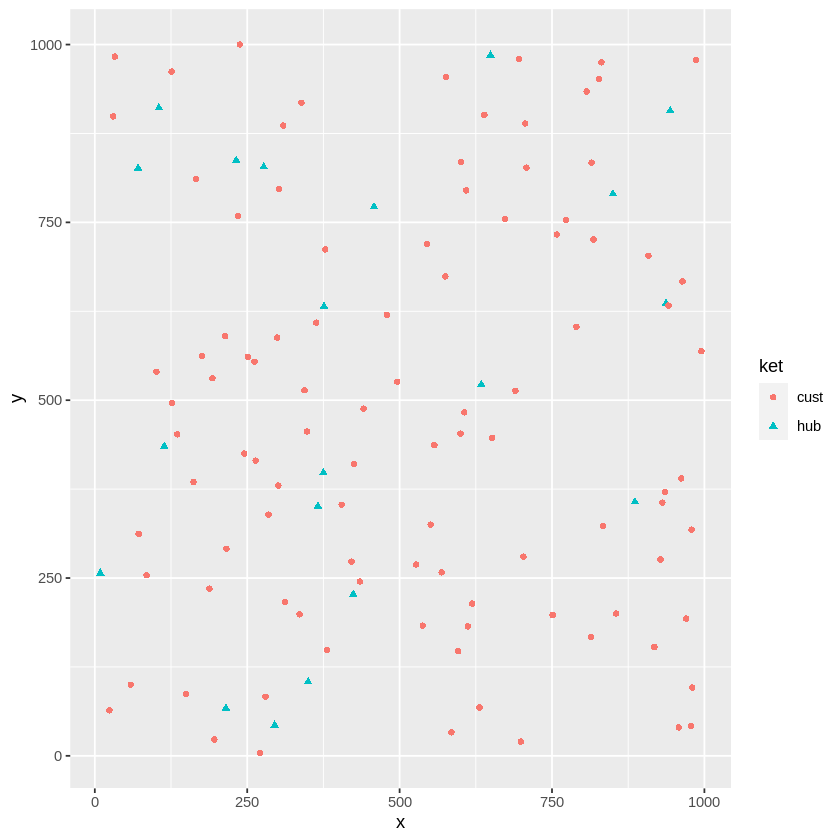

In [132]:
# create data dulu
jarak = 1000
titik = 120

data = data.frame(
  x = sample(jarak,titik),
  y = sample(jarak,titik),
  ket = c(rep("hub",20),rep("cust",titik-20))
)

data = 
  data %>%
  rowwise %>%
  mutate(cost_setup = ifelse(ket == "hub",
                             sample(30:95,1)*10,
                             NA)
        ) %>%
  ungroup()

data %>%
  ggplot(aes(x,y)) +
  geom_point(aes(color = ket,shape = ket))

In [133]:
head(data)

x,y,ket,cost_setup
<int>,<int>,<chr>,<dbl>
71,826,hub,810
295,43,hub,600
937,636,hub,600
944,907,hub,530
649,985,hub,910
634,522,hub,460


In [134]:
cost_deli = function(idx_1,idx_2){
  cust_ = cust_data[idx_1,]
  hub_ = hub_data[idx_2,]
  jarak = sqrt((cust_$x - hub_$x)^2 + (cust_$y - cust_$y)^2)
  jarak = round(jarak,2)
  return(jarak)
}

hub_data = data %>% filter(ket == "hub") %>% mutate(cost_setup = as.numeric(cost_setup)) %>% select(-ket)
cust_data = data %>% filter(ket != "hub") %>% select(-cost_setup,-ket)

head(hub_data)
head(cust_data)
cat("contoh jarak cust 100 ke hub 20")
cost_deli(100,20)

x,y,cost_setup
<int>,<int>,<dbl>
71,826,810
295,43,600
937,636,600
944,907,530
649,985,910
634,522,460


x,y
<int>,<int>
814,167
238,1000
600,453
790,603
101,540
962,390


contoh jarak cust 100 ke hub 20

[1] 69

In [135]:
n_hub = length(hub_data$x)
n_cust = length(cust_data$x)
n_hub
n_cust

[1] 20

[1] 100

In [136]:
model = 
  MIPModel() %>%
  # nilai 1 jika ada delivery antara hub j ke cust i
  add_variable(x[i,j],
               i = 1:n_cust,
               j = 1:n_hub,
               type = "binary") %>%
  # nilai 1 jika ada hub yang dibangun
  add_variable(y[j],
               j = 1:n_hub,
               type = "binary") %>%
  # objective function
  set_objective(sum_expr(cost_deli(i,j) * x[i,j], i = 1:n_cust, j = 1:n_hub) + sum_expr(hub_data$cost_setup[j] * y[j],j = 1:n_hub),
                "min"
               ) %>%
  # 1 cust harus dideliver dari 1 hub
  add_constraint(sum_expr(x[i,j],j = 1:n_hub) == 1, i = 1:n_cust) %>%
  # jika customer i dideliver oleh hub j, artinya dia harus dibangun
  add_constraint(x[i,j] <= y[j],
                 i = 1:n_cust,
                 j = 1:n_hub)

model


Mixed integer linear optimization problem
Variables:
  Continuous: 0 
  Integer: 0 
  Binary: 2020 
Model sense: minimize 
Constraints: 2100 

In [137]:
result <- solve_model(model, with_ROI(solver = "glpk", verbose = TRUE))


<SOLVER MSG>  ----
GLPK Simplex Optimizer, v4.65
2100 rows, 2020 columns, 6000 non-zeros
      0: obj =   0.000000000e+00 inf =   1.000e+02 (100)
    101: obj =   4.595300000e+04 inf =   0.000e+00 (0)
Perturbing LP to avoid stalling [398]...
Removing LP perturbation [698]...
*   698: obj =   7.092000000e+03 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
GLPK Integer Optimizer, v4.65
2100 rows, 2020 columns, 6000 non-zeros
2020 integer variables, all of which are binary
Integer optimization begins...
Long-step dual simplex will be used
+   698: mip =     not found yet >=              -inf        (1; 0)
+   698: >>>>>   7.092000000e+03 >=   7.092000000e+03   0.0% (1; 0)
+   698: mip =   7.092000000e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
<!SOLVER MSG> ----


In [149]:
result
final = 
  result %>% 
  get_solution(x[i,j]) %>%
  filter(value>0) %>%
  rename(cust_id = i,
         hub_id = j) %>%
  select(-variable,-value)
final

Status: optimal
Objective value: 7092

function () 
NA_real_
<bytecode: 0x55f3f2d2e970>
<environment: 0x55f3f83b8e40>

cust_id,hub_id
<int>,<int>
6,4
10,4
15,4
16,4
18,4
22,4
31,4
52,4
54,4


In [139]:
cust_data$cust_id = c(1:n_cust)
hub_data$hub_id = c(1:n_hub)

hub_data = hub_data %>% rename(x_hub = x,y_hub = y)
cust_data = cust_data %>% rename(x_cust = x,y_cust = y)

final = merge(final,hub_data,all.x = T)
final = merge(final,cust_data,all.x = T)
final

hub_id,cust_id,x_hub,y_hub,cost_setup
<int>,<int>,<int>,<int>,<dbl>
4,6,944,907,530
4,10,944,907,530
4,15,944,907,530
4,16,944,907,530
4,18,944,907,530
4,22,944,907,530
4,31,944,907,530
4,52,944,907,530
4,54,944,907,530


cust_id,hub_id,x_hub,y_hub,cost_setup,x_cust,y_cust
<int>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,9,850,790,330,814,167
2,7,232,837,350,238,1000
3,6,634,522,460,600,453
4,9,850,790,330,790,603
5,14,9,257,430,101,540
6,4,944,907,530,962,390
7,6,634,522,460,576,954
8,14,9,257,430,33,983
9,9,850,790,330,827,952


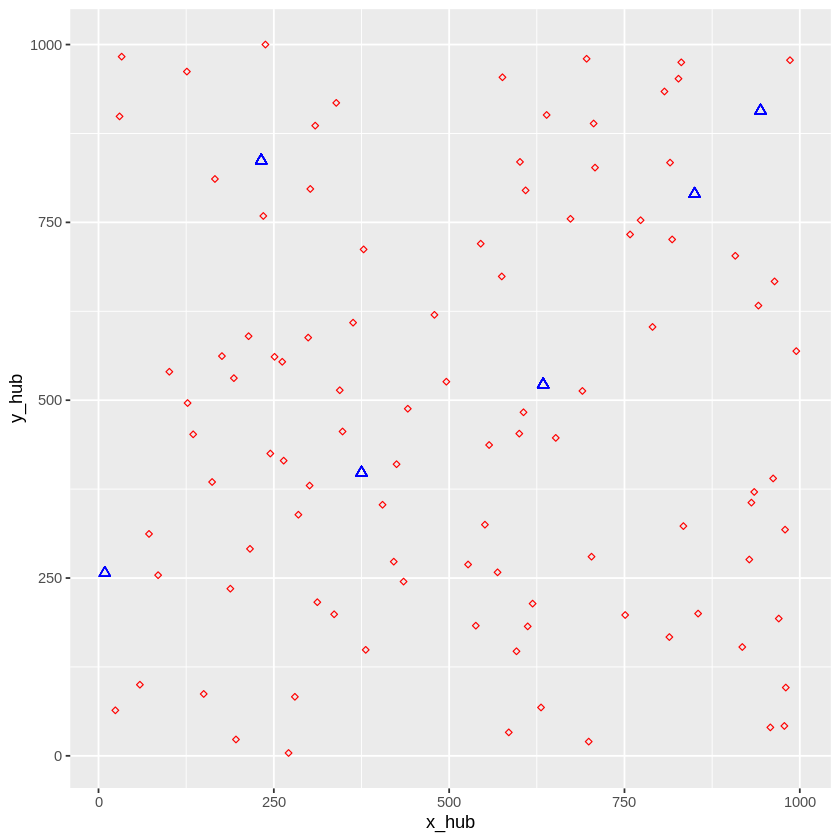

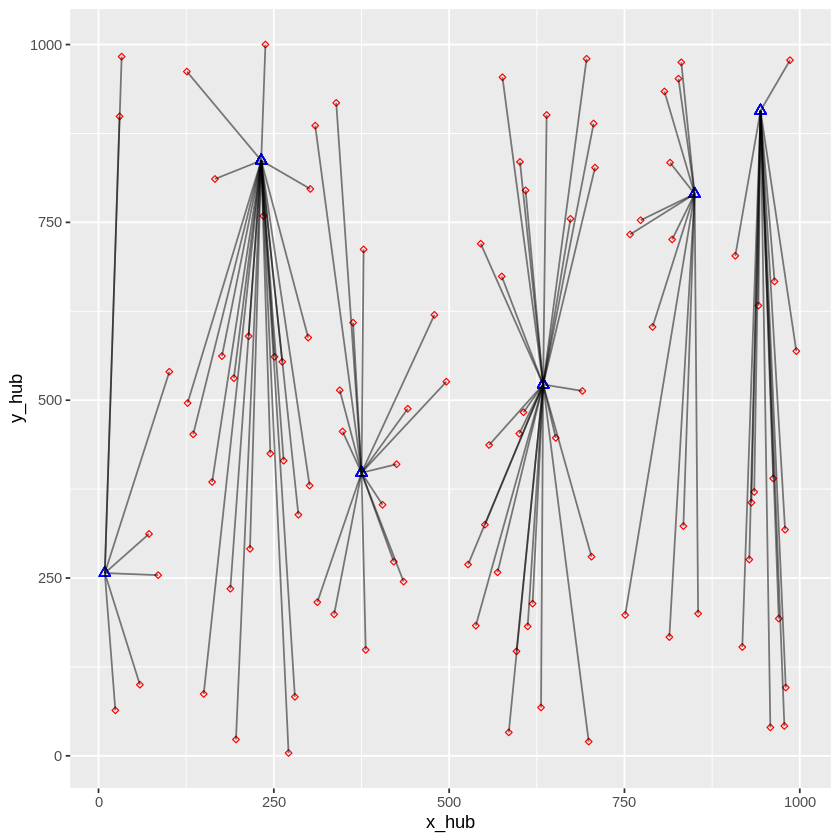

In [147]:
final %>%
  ggplot() +
  geom_point(aes(x_hub,y_hub),color = "blue",shape = 2,size = 2) +
  geom_point(aes(x_cust,y_cust),color = "red",shape = 5,size = 1)
  
final %>%
  ggplot() +
  geom_point(aes(x_hub,y_hub),color = "blue",shape = 2,size = 2) +
  geom_point(aes(x_cust,y_cust),color = "red",shape = 5,size = 1) +
  geom_segment(aes(x = x_hub,
                   y = y_hub,
                   xend = x_cust,
                   yend = y_cust),
                   alpha = .5
              )
  